## **Capstone MDS - DecisionTreeRegressor**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [32]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import graphviz

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from scipy.stats import randint, uniform
from matplotlib.ticker import EngFormatter

In [33]:
# función cálculo R2, RMSE y MSE
def R2_RMSE(y_true, y_pred):
  # cálculo de R2 y RMSE
  r2 = r2_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  
  return print('R2:',r2), print('RMSE:',rmse), print('MSE:', mse)

## **_1. Lectura (carga) de los Datos_**

In [34]:
# importamos archivo
df = pd.read_csv('../Data/df_final_pay.csv')

In [35]:
# miramos el dataframe
df.head()

,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0
1,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,396.0,96.0,240.0,0.0,132.0,24.0
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,394.0,96.0,240.0,0.0,132.0,24.0
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,95.0,396.0,96.0,240.0,0.0,132.0,24.0
4,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0


In [36]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 85 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_2023            1567 non-null   bool   
 1   year_2024            1567 non-null   bool   
 2   month_2              1567 non-null   bool   
 3   month_3              1567 non-null   bool   
 4   month_4              1567 non-null   bool   
 5   month_5              1567 non-null   bool   
 6   month_6              1567 non-null   bool   
 7   month_7              1567 non-null   bool   
 8   month_8              1567 non-null   bool   
 9   month_9              1567 non-null   bool   
 10  month_10             1567 non-null   bool   
 11  month_11             1567 non-null   bool   
 12  month_12             1567 non-null   bool   
 13  day_2                1567 non-null   bool   
 14  day_3                1567 non-null   bool   
 15  day_4                1567 non-null   b

## **_2 Preparación del DataFrame_**

In [37]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [38]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21',
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'shift_B', 'crew_E2', 'crew_E3',
       'crew_E4', 'total', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'som_excl', 'demora', 'r_prog',
       'r_noprg', 'waiting', 'queued', 'material_tonnage', 'payload',
       'distance', 'distance_down', 'distance_down_level', 'distance_up',
       'distance_up_level', 'expected_time', 'lift_down', 'lift_down_level',
       'lift_up', 'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC',
     

In [39]:
# cálculamos la desviaicón estándar y la media de payload
std_y = df['payload'].std()
mean_y = df['payload'].mean()

print('Desviación Estándar:',std_y)
print('Media:',mean_y)

Desviación Estándar: 19936.05577427206
Media: 142357.4639507874


In [40]:
# estandarizamos las variables numéricas
col_num = df.drop('payload', axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

## **_3 Modelo DecisionTreeRegressor_**

In [41]:
# definimos el tamaño del set de test
test_size = 0.3

In [42]:
# separamos los datos en X e y
X = df.drop('payload', axis=1)
y = df['payload']

# dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

In [43]:
# Ajustar los hiperparámetros para prevenir el sobreajuste
model = DecisionTreeRegressor(max_depth=5, min_samples_split=20, min_samples_leaf=10)


In [44]:
# Entrenar el modelo
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)

###   _3.1 Predicciones en el conjunto de entrenamiento_

In [45]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_train = model.predict(X_train)

In [46]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train, predictions_train)

R2: 0.8064921055063935
RMSE: 8760.826074859207
MSE: 76752073.51393297


(None, None, None)

###  _3.2 Predicciones en el conjunto de testeo_

In [47]:
# Realizar predicciones en el conjunto de test
predictions_test = model.predict(X_test)

In [48]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_test, predictions_test)

R2: 0.6854050894174166
RMSE: 11195.0890380273
MSE: 125330018.56935899


(None, None, None)

In [49]:
# Graficar el árbol de decisión
dot_data = export_graphviz(model, out_file=None, 
                            feature_names=X_train.columns,  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("payload_tree")

'payload_tree.pdf'

## **_4 Optimización del Modelo_**

### _4.1 Selección de Variables (LassoCV)_

In [50]:
# buscamos alpha optimo con LassoCV
alpha_values = np.linspace(0.01, 300, 3000)

# Crea un objeto LassoCV
lasso_cv = LassoCV(alphas=alpha_values, cv=5)

# Ajusta el modelo a los datos de entrenamiento
lasso_cv.fit(X_train, y_train)

# Valor óptimo de alpha
best_alpha = lasso_cv.alpha_

# Evalúa el modelo en el conjunto de prueba
score = lasso_cv.score(X_test, y_test)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Puntuación en el conjunto de prueba: {score}")

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50431264.29451752, tolerance: 35584840.12871909
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68618299.67835236, tolerance: 35584840.12871909
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49252254.03378296, tolerance: 35584840.12871909
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/py312/lib/python3.12/site-packages

Mejor valor de alpha: 57.227165721907305
Puntuación en el conjunto de prueba: 0.8149567521522341


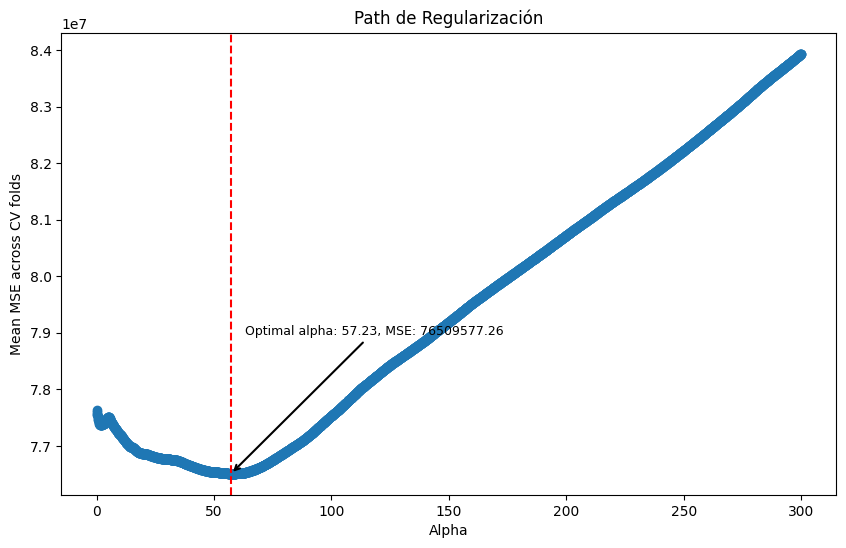

In [51]:
# Graficar MSE vs. Alpha
plt.figure(figsize=(10,6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE across CV folds')
plt.title('Path de Regularización')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')

# Anotar el valor óptimo de alpha en el gráfico
plt.annotate(f'Optimal alpha: {lasso_cv.alpha_:.2f}, MSE: {np.min(np.mean(lasso_cv.mse_path_, axis=1)):.2f}',
             xy=(lasso_cv.alpha_, np.min(np.mean(lasso_cv.mse_path_, axis=1))),
             xycoords='data', xytext=(10,100), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)

plt.show()

In [52]:
# Aplicar Lasso para la selección de características
lasso = Lasso(alpha=lasso_cv.alpha_)  
lasso.fit(X_train, y_train)

# Seleccionar las características que tienen coeficientes no nulos
selected_features = X_train.columns[lasso.coef_ != 0]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['year_2023', 'year_2024', 'month_3', 'month_5', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'day_2', 'day_5', 'day_7', 'day_10',
       'day_11', 'day_12', 'shift_B', 'crew_E2', 'crew_E3', 'crew_E4', 'total',
       'efectivo', 'mecanica', 'electrica', 'mant_excl', 'mec_excl',
       'elec_excl', 'som_excl', 'demora', 'r_prog', 'r_noprg', 'waiting',
       'queued', 'material_tonnage', 'distance_down_level', 'distance_up',
       'expected_time', 'lift_down', 'lift_up', 'lift_up_level', 'CAT 798-AC',
       'Kom.930E-4', 'Kom.930E-4SE', 'Kom.930EN', 'Kom.930ER', 'Kom.930ER-MT',
       'Kom.980E5', 'Komatsu AHS'],
      dtype='object')


In [53]:
len(selected_features)

47

> Volvemos ajustar el modelo con las variables seleccionadas

In [54]:
# separamos los datos en train y test
X_lasso= df[selected_features]
y_lasso = df['payload']

# dividimos los datos en train y test
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=test_size, random_state=42)

In [55]:
# Inicializar el regresor DecisionTree
model_lasso = DecisionTreeRegressor(max_depth=5, min_samples_split=20, min_samples_leaf=10)

In [56]:
# Entrenar el modelo DecisionTree
model_lasso.fit(X_train_lasso, y_train_lasso)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)

#### 4.1.1 Predicciones en el conjunto de entrenamiento

In [57]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train = model_lasso.predict(X_train_lasso)

In [58]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train)

R2: 0.8056434903457632
RMSE: 8780.01505090915
MSE: 77088664.29419121


(None, None, None)

#### 4.1.2 Predicciones en el conjunto de testeo

In [59]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test = model_lasso.predict(X_test_lasso)

In [60]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test)

R2: 0.7482511597192485
RMSE: 10014.642372934642
MSE: 100293061.85777801


(None, None, None)

In [61]:
# Graficar el árbol de decisión
dot_data_lasso= export_graphviz(model_lasso, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True,
                            proportion=True
                            ) 
# Modifica el archivo DOT para tener una orientación vertical
dot_data_lasso = dot_data_lasso.replace('digraph Tree {', 'digraph Tree {\nrankdir=LR;')

graph = graphviz.Source(dot_data_lasso)  
graph.render("payload_tree_lasso")

'payload_tree_lasso.pdf'

### _4.2 Poda Arbol (LassoCV)_

In [62]:
# Calcular el error cuadrático medio en el conjunto de prueba
y_pred_lasso = model_lasso.predict(X_test_lasso)
mse_lasso = mean_squared_error(y_test_lasso, y_pred_lasso)
print(f"Error cuadrático medio sin poda: {mse_lasso}")

# Podar el árbol
path = model_lasso.cost_complexity_pruning_path(X_train_lasso, y_train_lasso)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

model_lassos = []
for ccp_alpha in ccp_alphas:
    model_lasso = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    model_lasso.fit(X_train_lasso, y_train_lasso)
    model_lassos.append(model_lasso)

# Eliminar el último regresor, ya que corresponde al árbol no podado
model_lassos = model_lassos[:-1]
ccp_alphas = ccp_alphas[:-1]

# Evaluar el error cuadrático medio de cada árbol podado en el conjunto de prueba
mses = [mean_squared_error(y_test_lasso, model_lasso.predict(X_test_lasso)) for model_lasso in model_lassos]

# Encontrar el índice del mejor árbol (el que tiene el menor error cuadrático medio)
best_index = mses.index(min(mses))
best_model_lasso = model_lassos[best_index]
best_ccp_alpha = ccp_alphas[best_index]

# Calcular y mostrar el error cuadrático medio del mejor árbol podado
y_pred_pruned = best_model_lasso.predict(X_test_lasso)
mse_pruned = mean_squared_error(y_test_lasso, y_pred_pruned)
print(f"Error cuadrático medio con poda: {mse_pruned}")

Error cuadrático medio sin poda: 100293061.85777801
Error cuadrático medio con poda: 95021231.60883194


In [63]:
# Graficar el árbol de decisión
dot_data_lasso_pruned= export_graphviz(best_model_lasso, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True,
                            proportion=True
                            )
# Modifica el archivo DOT para tener una orientación vertical
dot_data_lasso_pruned = dot_data_lasso_pruned.replace('digraph Tree {', 'digraph Tree {\nrankdir=LR;')

graph = graphviz.Source(dot_data_lasso_pruned)  
graph.render("payload_tree_lasso_pruned")

'payload_tree_lasso_pruned.pdf'

#### _4.2.1 Predicciones en el conjunto de entrenamiento_

In [52]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train_pruned = best_model_lasso.predict(X_train_lasso)

In [53]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train_pruned)

R2: 0.8053102012885918
RMSE: 8787.539958348456
MSE: 77220858.51957077


(None, None, None)

#### _4.2.2 Predicciones en el conjunto de testeo_

In [54]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test_pruned = best_model_lasso.predict(X_test_lasso)

In [55]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test_pruned)

R2: 0.7614841503842575
RMSE: 9747.88344251366
MSE: 95021231.60883194


(None, None, None)

## _**5 Modelo DecisionTreeRegressor Optimizado**_

### _5.1 Hiperparámetros_

In [35]:
# Definir los hiperparámetros para la búsqueda
param_dist_tree = {
    'max_depth': randint(1, 200),
    'min_samples_split': randint(2, 200),
    'min_samples_leaf': randint(1, 200),
    'max_features':  [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'min_impurity_decrease': uniform(0,1)
}

# Crear la búsqueda de hiperparámetros para DecisionTreeRegressor
random_search_tree = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(),
    param_distributions=param_dist_tree,
    n_iter=10000,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_tree.fit(X_train_lasso, y_train_lasso)

# Mejor combinación de hiperparámetros para el árbol de decisión
best_params_tree = random_search_tree.best_params_
print("Best parameters for DecisionTreeRegressor: ", best_params_tree)


Best parameters for DecisionTreeRegressor:  {'criterion': 'friedman_mse', 'max_depth': 52, 'max_features': None, 'min_impurity_decrease': 0.321240877788587, 'min_samples_leaf': 25, 'min_samples_split': 36}


In [36]:
# Crear el DecisionTreeRegressor con los mejores parámetros encontrados
best_tree = DecisionTreeRegressor(**best_params_tree)

In [37]:
# Entrenar el modelo DecisionTreeRegressor con los mejores hiperparámetros
best_tree.fit(X_train_lasso, y_train_lasso)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=52,
                      min_impurity_decrease=0.321240877788587,
                      min_samples_leaf=25, min_samples_split=36)

#### _5.1.1 Predicciones en el conjunto de entrenamiento_

In [56]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_lasso_hiper_train = best_tree.predict(X_train_lasso)

# Realizar predicciones en el conjunto de prueba
predictions_lasso_hiper_test = best_tree.predict(X_test_lasso)

In [57]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_hiper_train)

R2: 0.8060012926726394
RMSE: 8771.92950491752
MSE: 76946747.23924252


(None, None, None)

#### _5.1.2 Predicciones en el conjunto de testeo_

In [58]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_hiper_test)

R2: 0.7341812180099941
RMSE: 10290.690996300871
MSE: 105898321.18134783


(None, None, None)

In [41]:
# Graficar el árbol de decisión
dot_data_best = export_graphviz(best_tree, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data_best)  
graph.render("payload_tree_best")

'payload_tree_best.pdf'

### _5.2 Poda Árbol Hiper parametrizado_

In [59]:
# Calcular el error cuadrático medio en el conjunto de prueba
y_pred_best_tree = best_tree.predict(X_test_lasso)
mse_best_tree = mean_squared_error(y_test_lasso, y_pred_best_tree)
print(f"Error cuadrático medio sin poda: {mse_best_tree}")

# Podar el árbol
path = best_tree.cost_complexity_pruning_path(X_train_lasso, y_train_lasso)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

model_best_trees = []
for ccp_alpha in ccp_alphas:
    best_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    best_tree.fit(X_train_lasso, y_train_lasso)
    model_best_trees.append(best_tree)

# Eliminar el último regresor, ya que corresponde al árbol no podado
model_best_trees = model_best_trees[:-1]
ccp_alphas = ccp_alphas[:-1]

# Evaluar el error cuadrático medio de cada árbol podado en el conjunto de prueba
mses = [mean_squared_error(y_test_lasso, best_tree.predict(X_test_lasso)) for best_tree in model_best_trees]

# Encontrar el índice del mejor árbol (el que tiene el menor error cuadrático medio)
best_index = mses.index(min(mses))
best_model_tree = model_best_trees[best_index]
best_ccp_alpha = ccp_alphas[best_index]

# Calcular y mostrar el error cuadrático medio del mejor árbol podado
y_pred_pruned = best_model_tree.predict(X_test_lasso)
mse_pruned = mean_squared_error(y_test_lasso, y_pred_pruned)
print(f"Error cuadrático medio con poda: {mse_pruned}")

Error cuadrático medio sin poda: 105898321.18134783
Error cuadrático medio con poda: 94722109.00032969


In [60]:
# Graficar el árbol de decisión
dot_data_best_pruned = export_graphviz(best_model_tree, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data_best_pruned)  
graph.render("payload_tree_best_pruned")

'payload_tree_best_pruned.pdf'

#### _5.2.1 Predicciones en el conjunto de entrenamiento_

In [61]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_best_train_pruned = best_model_tree.predict(X_train_lasso)

In [62]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_best_train_pruned)

R2: 0.8135199893893033
RMSE: 8600.265475884382
MSE: 73964566.2556888


(None, None, None)

#### _5.2.2 Predicciones en el conjunto de testeo_

In [63]:
# Realizar predicciones en el conjunto de test
predictions_best_test_pruned = best_model_tree.predict(X_test_lasso)

In [65]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_best_test_pruned)

R2: 0.7622349876644972
RMSE: 9732.528397098551
MSE: 94722109.00032969


(None, None, None)